## Port Elizabeth Crime Forecasting
### Anil Abraham 2023

#### The goal of this project is to use machine learning techniques to forecast crime in Port Elizabeth. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots.

### Importing libraries

In [97]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point, Polygon #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express

In [98]:
#sns.set_style("darkgrid")

### Data preprocessing

In [99]:
df = pd.read_csv('crimedata.csv', thousands=',')

print(f'Null values found\n{df.isna().sum()}') #Check for null values

print(f'\n\n{df.columns}') #List all feature names

Null values found
Crime                  0
Crimes                 0
Police Station         0
Province               0
Crime Category         0
Latitude               0
Longitude              0
Latitude, Longitude    0
Year                   0
dtype: int64


Index(['Crime', 'Crimes', 'Police Station', 'Province', 'Crime Category',
       'Latitude', 'Longitude', 'Latitude, Longitude', 'Year'],
      dtype='object')


### What are the datatypes used?

In [100]:
df.dtypes

Crime                   object
Crimes                   int64
Police Station          object
Province                object
Crime Category          object
Latitude               float64
Longitude              float64
Latitude, Longitude     object
Year                     int64
dtype: object

Crimes is the *number* of crimes (of some specific type) that took place in one year. Therefore, it shouldn't be a string/object if we are to analyse number of crimes. Let's convert it to an int64

<span style="color: #FFFF00">Does 1,4 crimes in a year make sense? What should we do with this?</span>

#### What does the csv file look like?

In [101]:
df

,Crime,Crimes,Police Station,Province,Crime Category,Latitude,Longitude,"Latitude, Longitude",Year
0,Murder,5,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
1,Attempted murder,3,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
2,Assault with the intent to inflict grievous bo...,67,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
3,Common assault,31,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
4,Common robbery,2,Aberdeen,Eastern Cape,Contact Crimes,-32.476960,24.060513,"-32.4769604, 24.0605132",2010
...,...,...,...,...,...,...,...,...,...
345295,Shoplifting,210,Wynberg,Western Cape,Other Serious Crimes,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345296,Illegal possession of firearms and ammunition,8,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345297,Drug-related crime,581,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019
345298,Driving under the influence of alcohol or drugs,252,Wynberg,Western Cape,Crime detected as a result of Police Action,-34.004107,18.464883,"-34.0041069, 18.4648833",2019


In [102]:
df['Crime Category'].value_counts().sort_values(ascending=False)

Contact Crimes                                 69060
Aggravated Robbery                             69060
Property-Related Crimes                        57550
Sexual Offences                                46040
Crime detected as a result of Police Action    46040
Other Serious Crimes                           34530
Contact-Related Crimes                         23020
Name: Crime Category, dtype: int64

##### As we can see, most crimes committed in South Africa from 2010 - 2019 were Contact Crimes.

#### Features of crimedata.csv are:
<ul>
  <li>Crime (what crime was committed)</li>
  <li>Crimes (How many times a specific crime was committed for that year)</li>
  <li>Police Station (Which station was the crime reported to)</li>
  <li>Province</li>
  <li>Crime Category (Contact, property-related, aggravated robbery, sexual offence, etc)</li>
  <li>Latitude</li>
  <li>Longitude</li>
  <li>Latitude, Longitude</li>
  <li>Year</li>
</ul>

#### Limit provinces to only Eastern Cape

In [103]:
#df = df.drop(['Latitude, Longitude'], axis=1)
df = df[df['Province'] == 'Eastern Cape']
df.to_csv('ECcrimerates.csv', encoding='utf-8', index=False) #Create new csv file with crime information within Eastern Cape only
df_EC = pd.read_csv('ECcrimerates.csv') #Set df equal to the new cleaned CSV.

#### Let's load the SHAPE file of South Africa

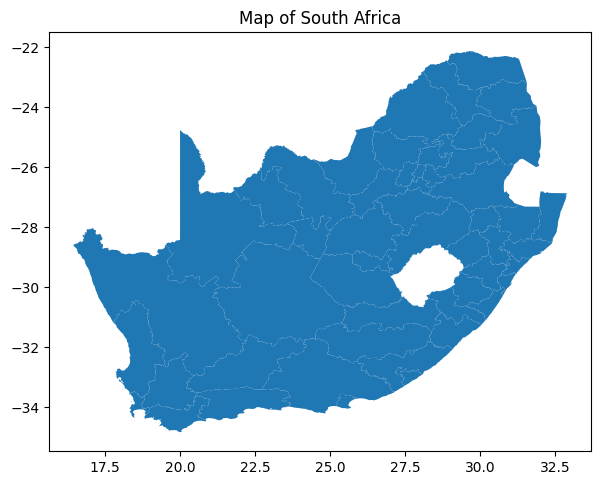

In [104]:
map = gpd.read_file("gadm41_ZAF_shp\\gadm41_ZAF_2.shp")
fig, ax = plt.subplots(figsize=(7,7))
map.plot(aspect=1,ax = ax)
plt.title('Map of South Africa')
plt.show()

#### After some careful analysis, I found out that there is some incorrect data that has been input. The Police Station 'Doringkloof' does not exist within the Eastern Cape. Doringkloof is a suburb in Gauteng. Therefore, we remove this.

In [105]:
df = df[df['Police Station'] != 'Doringkloof']
df.describe()

,Crimes,Latitude,Longitude,Year
count,58200.000000,58200.000000,58200.000000,58200.000000
mean,35.203351,-32.373939,27.089175,2014.500000
std,91.869912,1.042523,1.411054,2.872306
min,-1.000000,-34.167017,23.152191,2010.000000
25%,0.000000,-33.149218,26.085341,2012.000000
50%,5.000000,-32.569626,27.244802,2014.500000
75%,27.000000,-31.524087,28.000901,2017.000000
max,1734.000000,-30.261515,30.183881,2019.000000


#### Let's take our map of South Africa and plot all the coordinates of the police stations in the Eastern Cape only.

c:\Users\G20A2632\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



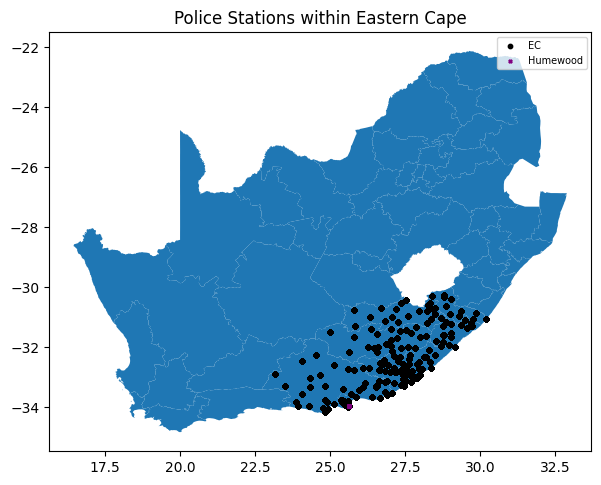

In [106]:
#A GeoDataFrame is a dataframe that accepts a geometry column (POINT pairs)
geo_df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])])

fig, ax = plt.subplots(figsize=(7,7))
map.plot(aspect=1,ax=ax) #Plot the map of South Africa
geo_df.plot(aspect=1,ax=ax,markersize=10,color='black',marker='o',label='EC') #Plot the latitude longitude pairs onto the same SA map.
geo_df[geo_df['Police Station'] == 'Humewood'].plot(aspect=1,ax=ax,markersize=5,color='purple',marker='X',label='Humewood')
plt.title('Police Stations within Eastern Cape')
plt.legend(prop={'size':7})
plt.show()

#### Police stations within Port Elizabeth are:
<ul>
<li>Walmer</li>
<li>Swartkops</li>
<li>Mount Road</li>
<li>Humewood</li>
<li>Kwadwesi</li>
<li>Kabega Park</li>
<li>Algoapark</li>
<li>Gelvandale</li>
<li>Uitenhage</li>
<li>Bethelsdorp</li>
<li>Motherwell</li>
<li>New Brighton</li>
<li>Despatch</li>
<li>Kwazakele</li>
</ul>

In [107]:
stations = ["Walmer", "Swartkops", "New Brighton", "Mount Road", "Humewood", "Kwadwesi", "Kabega Park", "Algoapark", "Gelvandale", "Uitenhage", "Bethelsdorp", "Motherwell"
            , "Despatch", "Kwazakele", "Kamesh", "Kwanobuhle", "Ikamvelihle"]
df = df[df['Police Station'].isin(stations)]
df.to_csv('PEcrimerates.csv', encoding='utf-8', index=False) #Create new csv file with crime information within PE only
# print(geo_df['Crime Category'].nunique())
# df.drop(['Latitude', 'Longitude', 'Crime', 'Province', 'Crime Category', 'Year'], inplace=True, axis=1)
# df = df.groupby(['Police Station'])['Crimes'].agg(Crimes='sum')
# print(df)

#### Let's plot the police stations within Port Elizabeth only.

In [108]:
#A GeoDataFrame is a dataframe that accepts a geometry column (POINT pairs)
geo_df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])])

# fig, ax = plt.subplots(figsize=(10,10))
# map = gpd.read_file("gadm41_ZAF_shp\\gadm41_ZAF_4.shp")
# map.plot(aspect=1,ax=ax) #Plot the map of South Africa
#geo_df['Crimes'] = geo_df['Crimes'].astype('float64')
# geo_df.plot(aspect=1,ax=ax, markersize='Crimes', color='purple') #Plot the latitude longitude pairs onto the same SA map.
# #geo_df[geo_df['Police Station'] == 'Kwazakele'].plot(aspect=1,ax=ax,markersize=40,color='purple',marker='o',label='Kwazakele')
# ax.set_ylim([-33.75, -34])
# ax.set_xlim([25.3, 25.7])
# plt.title('Police Stations within Port Elizabeth')
# plt.legend(prop={'size':7})
# for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['Police Station']):
#     ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")
# plt.show()

c:\Users\G20A2632\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [109]:
sum_crimes = geo_df.groupby(['Police Station'])['Crimes'].sum()
sum_crimes = sum_crimes.reset_index()
sum_crimes['Latitude'] = geo_df['Latitude'].unique()
sum_crimes['Longitude'] = geo_df['Longitude'].unique()

In [110]:
import plotly.express as px

fig = px.scatter_mapbox(sum_crimes, lat="Latitude", lon="Longitude", hover_name="Police Station", hover_data=["Crimes"],
                        color="Crimes", color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'], zoom=3, height=600, size='Crimes', size_max=30)
fig.update_layout(mapbox_style="carto-darkmatter")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<span style="color: #FFFF00">Kwazakele is a police station in Port Elizabeth, but displays outside of PE. What should I do?</span>

In [111]:
geo_df

,Crime,Crimes,Police Station,Province,Crime Category,Latitude,Longitude,"Latitude, Longitude",Year,geometry
150,Murder,20,Algoapark,Eastern Cape,Contact Crimes,-33.903171,25.570496,"-33.9031712, 25.5704957",2010,POINT (25.57050 -33.90317)
151,Attempted murder,14,Algoapark,Eastern Cape,Contact Crimes,-33.903171,25.570496,"-33.9031712, 25.5704957",2010,POINT (25.57050 -33.90317)
152,Assault with the intent to inflict grievous bo...,158,Algoapark,Eastern Cape,Contact Crimes,-33.903171,25.570496,"-33.9031712, 25.5704957",2010,POINT (25.57050 -33.90317)
153,Common assault,369,Algoapark,Eastern Cape,Contact Crimes,-33.903171,25.570496,"-33.9031712, 25.5704957",2010,POINT (25.57050 -33.90317)
154,Common robbery,54,Algoapark,Eastern Cape,Contact Crimes,-33.903171,25.570496,"-33.9031712, 25.5704957",2010,POINT (25.57050 -33.90317)
...,...,...,...,...,...,...,...,...,...,...
316405,Shoplifting,127,Walmer,Eastern Cape,Other Serious Crimes,-33.978868,25.585376,"-33.9788678, 25.5853756",2019,POINT (25.58538 -33.97887)
316406,Illegal possession of firearms and ammunition,26,Walmer,Eastern Cape,Crime detected as a result of Police Action,-33.978868,25.585376,"-33.9788678, 25.5853756",2019,POINT (25.58538 -33.97887)
316407,Drug-related crime,305,Walmer,Eastern Cape,Crime detected as a result of Police Action,-33.978868,25.585376,"-33.9788678, 25.5853756",2019,POINT (25.58538 -33.97887)
316408,Driving under the influence of alcohol or drugs,154,Walmer,Eastern Cape,Crime detected as a result of Police Action,-33.978868,25.585376,"-33.9788678, 25.5853756",2019,POINT (25.58538 -33.97887)


### Let's do some EDA

In [131]:
df_grouped = df.groupby(['Police Station'])['Crimes'].sum()
df_grouped_year = df.groupby(['Police Station', 'Year'])['Crimes'].sum()

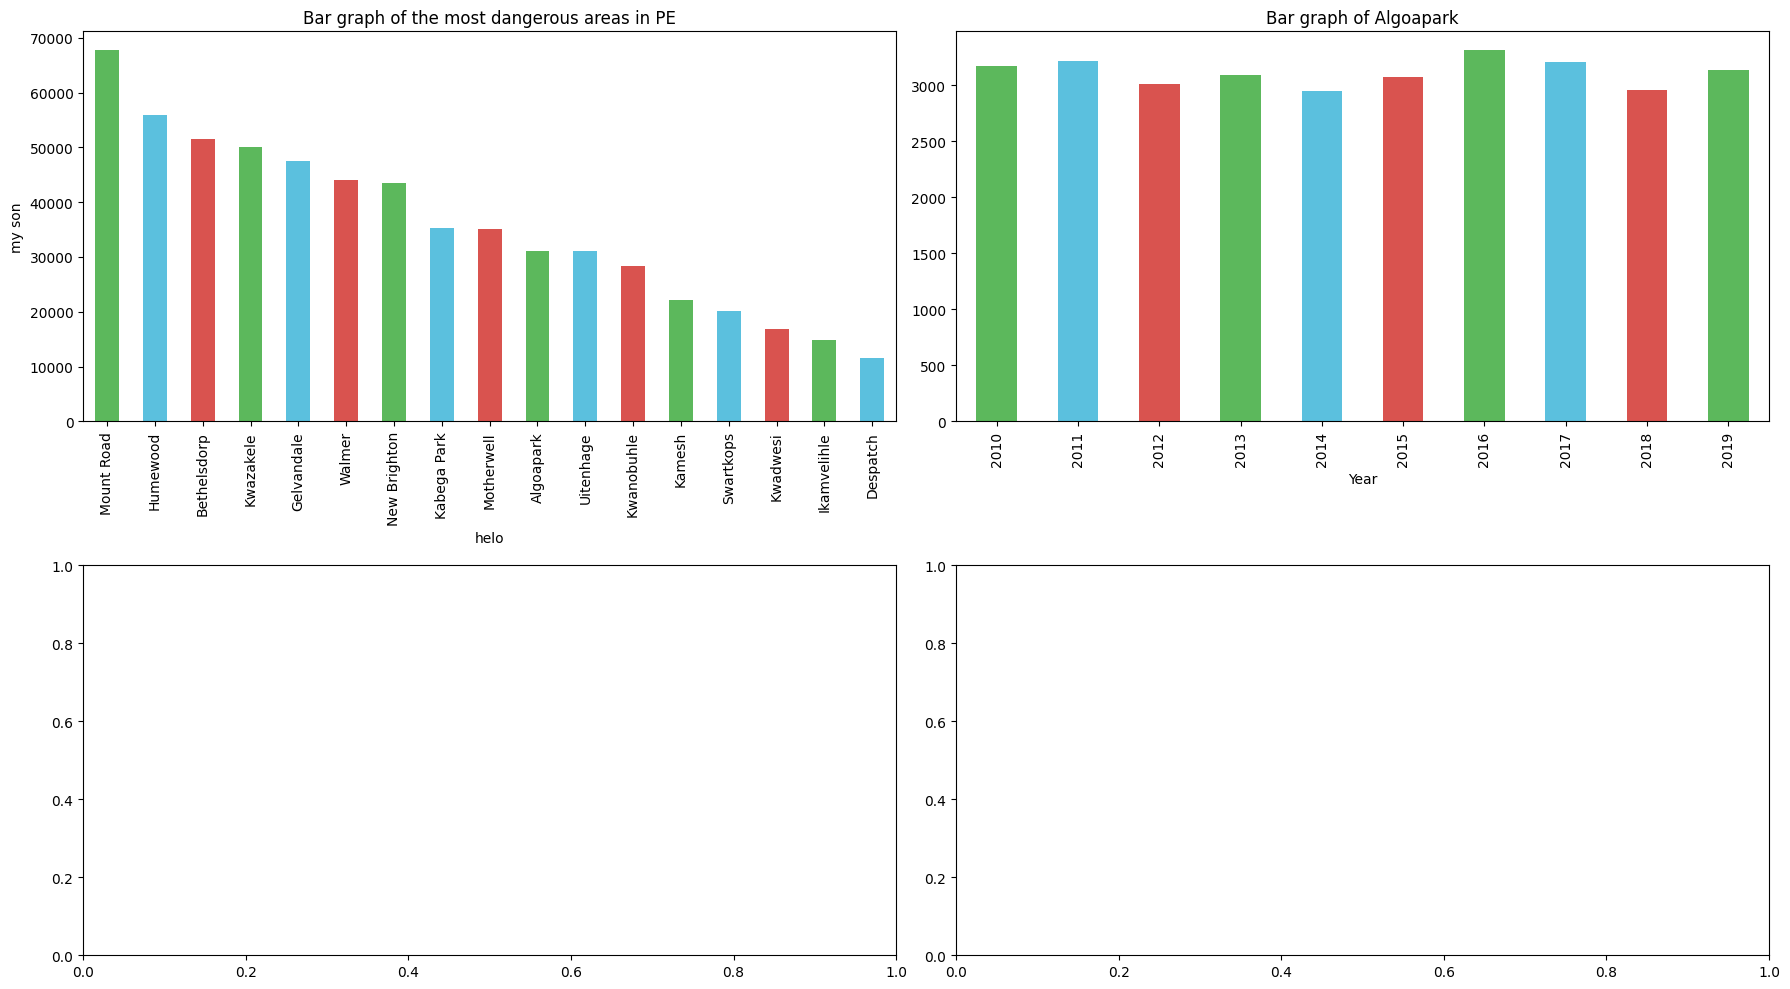

In [140]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

df_grouped.sort_values(ascending=False).plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,0])
df_grouped_year['Algoapark'].plot.bar(color=['#5cb85c','#5bc0de','#d9534f'], ax=axs[0,1])

axs[0,0].set_title('Bar graph of the most dangerous areas in PE')
axs[0,0].set_xlabel('helo')
axs[0,0].set_ylabel('my son'
                    )
axs[0,1].set_title('Bar graph of Algoapark')
plt.tight_layout()

### Thanks for reading!